In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.metrics import mean_squared_error

In [2]:
#this is our imports of csv files
test1_df = pd.read_csv('SE_rents2018_test1.csv', index_col=0)
test2_df = pd.read_csv('SE_rents2018_test2.csv', index_col=0)
test3_df = pd.read_csv('SE_rents2018_test3.csv', index_col=0)
train_df = pd.read_csv('SE_rents2018_train.csv', index_col=0)
# bedrooms, bathrooms, size_sqft, and year_built use for linear model.
# borough, neighborhood, has_doorman, and size_sqft for non-linear model. 

In [3]:

url = 'https://api.census.gov/data/2017/acs/acs5?'
params = {'get' : 'NAME,B19013_001E,B25058_001E',
          'for' : 'zip code tabulation area:*',}

r = requests.get(url, params=params)
print(r.url)

https://api.census.gov/data/2017/acs/acs5?get=NAME%2CB19013_001E%2CB25058_001E&for=zip+code+tabulation+area%3A%2A


In [4]:
#import median household income from census gov
income_df = pd.DataFrame(r.json()[1:], columns=r.json()[0])

In [5]:
income_df = (income_df
             .rename(
                 columns={
                          'B19013_001E' : 'Median Household Income',
                          'B25058_001E' : 'Median Rent',
                          'zip code tabulation area' : 'addr_zip',
                         }
             )
            )

In [6]:
income_df['addr_zip'] = income_df['addr_zip'].astype(int)
income_df['Median Rent'] = income_df['addr_zip'].astype(int)
income_df['Median Household Income'] = income_df['Median Household Income'].astype(int)

In [7]:
# # Here is the link to the data set. https://catalog.data.gov/dataset/demographic-statistics-by-zip-code-acfc9
# demographic_by_zipcode_df = pd.read_csv('Demographic_Statistics_By_Zip_Code.csv', index_col=0)
# print(demographic_by_zipcode_df.columns)
# test_merge_df = pd.merge(test_merge_df,demographic_by_zipcode_df, left_on = test_merge_df.addr_zip , right_index=True, how = 'left')


In [8]:
#imported heatmap to see correlation
def get_heatmap(df):
    corrmat = df.corr()
    top_corr = corrmat.index
    plt.figure(figsize=(len(df.columns),len(df.columns)))
    df_g = sns.heatmap(df[top_corr].corr(), annot=True, cmap="RdYlGn")
    return df_g

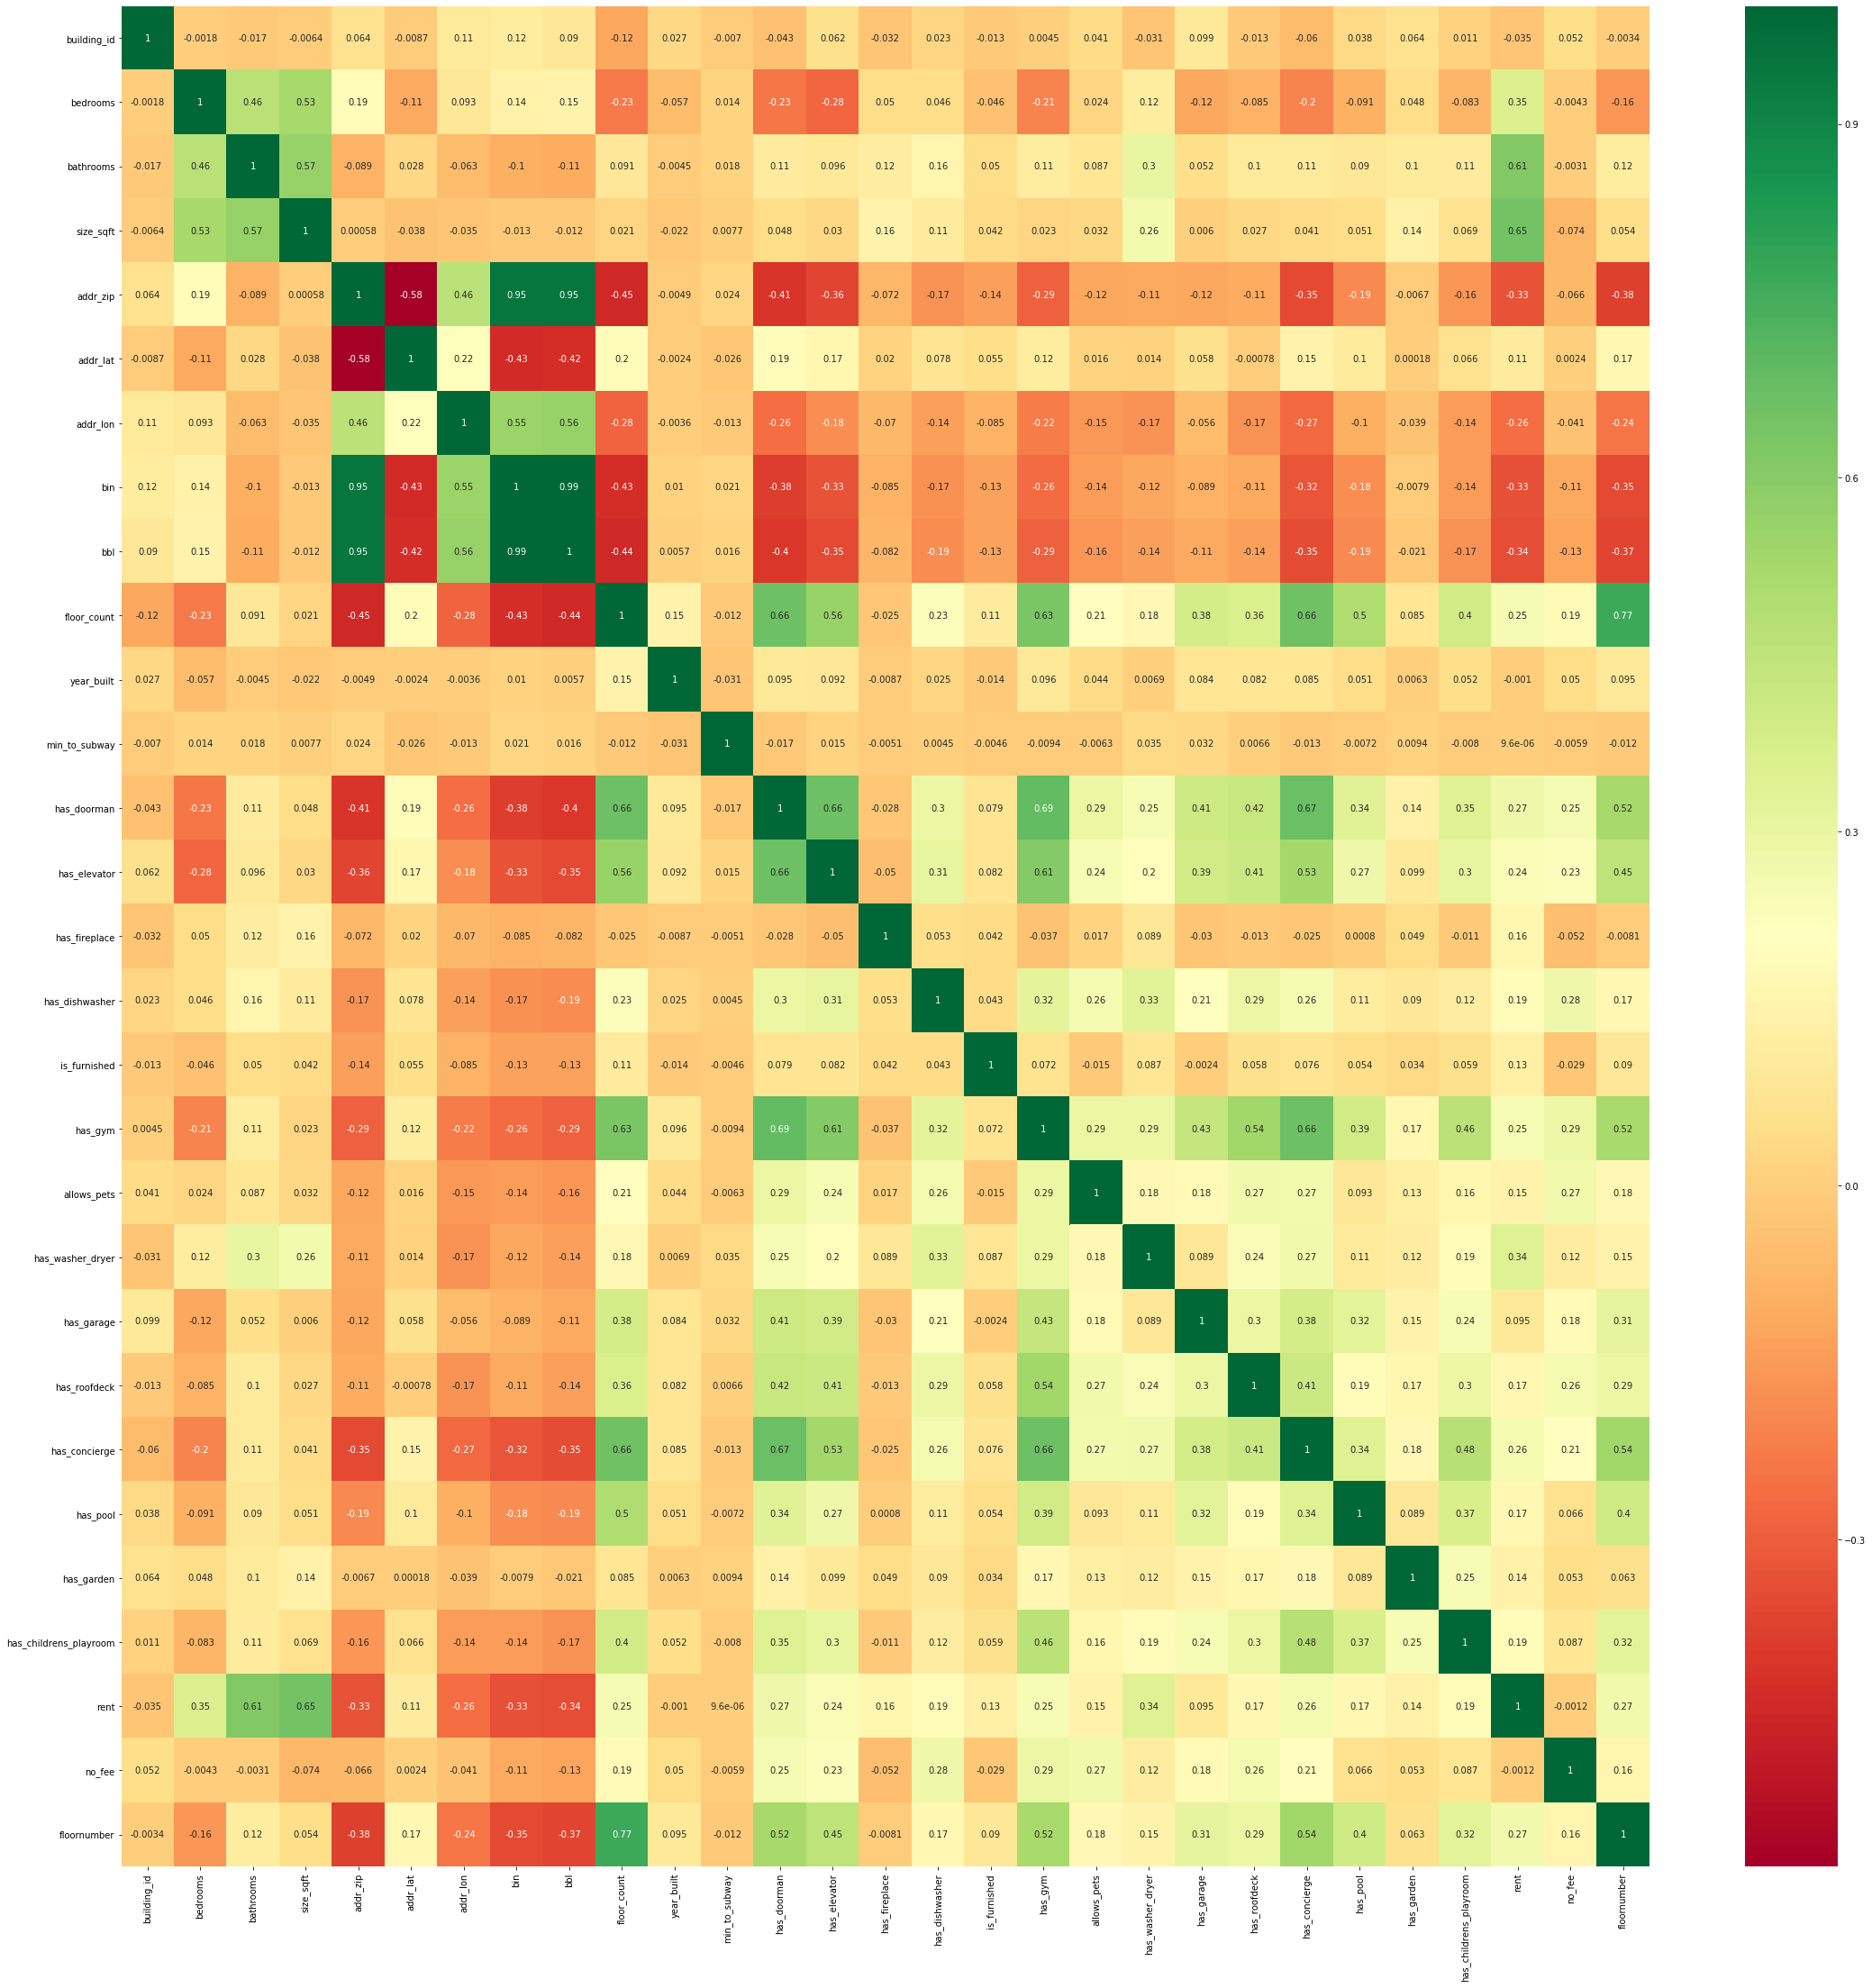

In [9]:
get_heatmap(train_df)

In [10]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


def train_linear_reg_model(X_train, y_train, X_test, y_test):
    """Trains and test linear regression model and returns mean_squared_error of
    y_test and y_predicted. 
    ----------
    X_train : data frame, shape = [n_samples, n_features]
        n_samples the number of samples
        n_features the number of features for each sample.
        
    y_train : data frame, shape = [n_samples]
        n_sample target values.
        
    X_test : data frame, shape = [n_samples, n_features]
        n_samples the number of samples
        n_features the number of features for each sample.
        
    y_test : data frame, shape = [n_samples]
        n_sample target values.
        
    Return 
        (data frame) y_prediction: predictions made from X_test
        (float) mean_squared_error of (y_test and y_prediction)
        (LinearRegression) returns the linear regression model.
    """

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    y_prediction = lr.predict(X_test)
    
    return lr ,y_prediction, mean_squared_error(y_test, y_prediction)

In [11]:
train_merge_df = train_df.merge(right=income_df,how='left', on='addr_zip')
test1_merge_df = test1_df.merge(right=income_df,how='left', on='addr_zip')
test2_merge_df = test2_df.merge(right=income_df,how='left', on='addr_zip')
test3_merge_df = test3_df.merge(right=income_df,how='left', on='addr_zip')

# Martin's cleaning data.
relfeatures_df = train_merge_df[['size_sqft', 'bathrooms', 'bedrooms', 'has_gym', 'bin', 'addr_zip', 'bbl', 'rent']].copy()

mv_percentages = train_merge_df.isna().sum()/len(train_merge_df)*100
mv_percentages
"""


"""
for name, percent in mv_percentages.iteritems():
    if(percent<5 and percent > 0):
        train_merge_df = train_merge_df[pd.notnull(train_merge_df[name])]
train_merge_df.shape

from pandas.api.types import is_numeric_dtype
mv_percentages_step2 = train_merge_df.isna().sum()/len(train_merge_df)*100
for name, percent in mv_percentages_step2.iteritems():
    if(percent>=5):
        print(name + ": " + str(train_merge_df[name].value_counts().idxmax()))
        if(is_numeric_dtype(train_merge_df[name])):
            train_merge_df[name].fillna(train_merge_df[name].median(), inplace=True)
        else:
            train_merge_df[name].fillna(train_merge_df[name].value_counts().idxmax(), inplace=True)
            
            
# CLEAN THE DATA HERE CLEAN TRAIN_MERGE_DF


floornumber: 2.0
line: A


Text(0.5, 0, 'bbl')

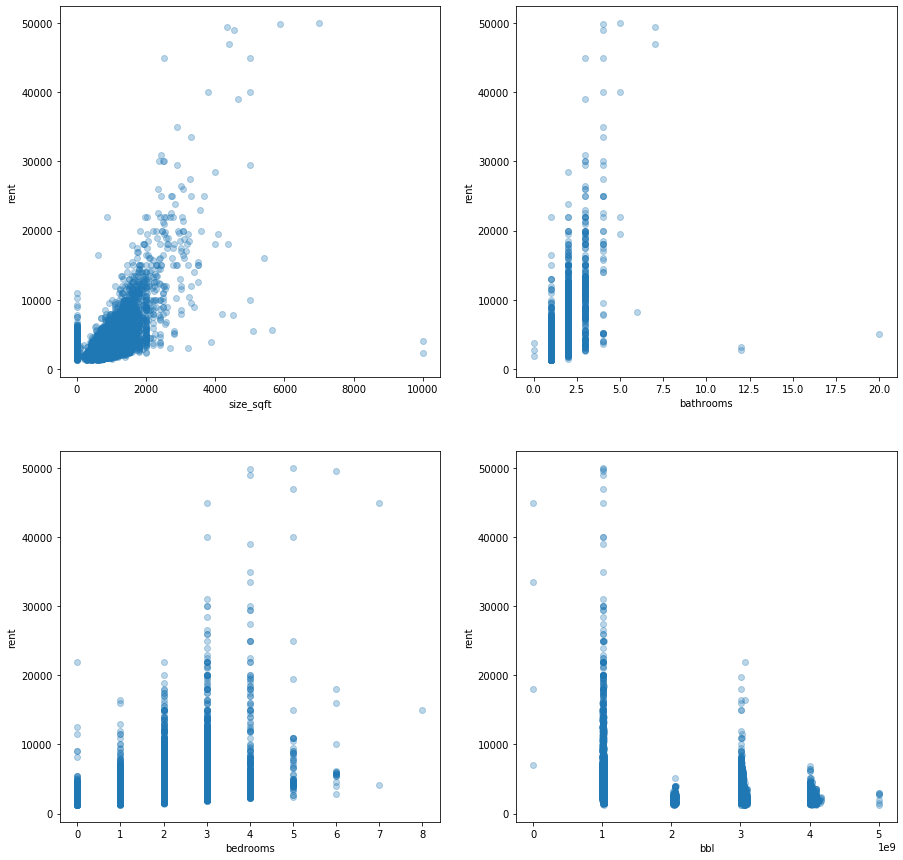

In [12]:
#created charts to see outlying datapoints

relfeatures_df = train_merge_df[['size_sqft', 'bathrooms', 'bedrooms', 'has_gym', 'bin', 'addr_zip', 'bbl', 'rent']].copy()


fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2, 1)
ax1.scatter(relfeatures_df["size_sqft"], relfeatures_df["rent"], alpha=0.3)
ax1.set_ylabel("rent")
ax1.set_xlabel("size_sqft")


ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(relfeatures_df["bathrooms"], relfeatures_df["rent"], alpha=0.3)
ax2.set_ylabel("rent")
ax2.set_xlabel("bathrooms")

ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(relfeatures_df["bedrooms"], relfeatures_df["rent"], alpha=0.3)
ax3.set_ylabel("rent")
ax3.set_xlabel("bedrooms")

ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(relfeatures_df["bbl"], relfeatures_df["rent"], alpha=0.3)
ax4.set_ylabel("rent")
ax4.set_xlabel("bbl")


In [13]:
train_merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11223 entries, 0 to 11999
Data columns (total 41 columns):
addr_unit                  11223 non-null object
building_id                11223 non-null int64
bedrooms                   11223 non-null int64
bathrooms                  11223 non-null float64
size_sqft                  11223 non-null float64
created_at                 11223 non-null object
addr_street                11223 non-null object
addr_city                  11223 non-null object
addr_zip                   11223 non-null int64
addr_lat                   11223 non-null float64
addr_lon                   11223 non-null float64
bin                        11223 non-null float64
bbl                        11223 non-null int64
floor_count                11223 non-null float64
year_built                 11223 non-null float64
min_to_subway              11223 non-null float64
has_doorman                11223 non-null int64
has_elevator               11223 non-null int64
has_fir

In [14]:
columns_needed = ['bedrooms','bathrooms', 'size_sqft','bbl','floor_count','Median Household Income','rent']
features = ['bedrooms','bathrooms', 'size_sqft','bbl','floor_count','Median Household Income']

train_merge_df = train_merge_df[columns_needed]

# Dataset contains one null value in bin. So I decided to drop it.
train_merge_df = train_merge_df.dropna(axis=0)

# Getting the target columns
train_merge_target = train_merge_df[['rent']]
# Getting the features for training.
train_merge_df = train_merge_df[features]

# Getting the target columns to get accuracy of predictions. 
test1_merge_target = test1_merge_df[['rent']]
# Extracting the columns needed for testing. Useing test1.csv file.
test1_merge_df = test1_merge_df[features]

test1_merge_df = test1_merge_df.fillna(test1_merge_df.median())


lr, y_prediction, mse = train_linear_reg_model(train_merge_df, train_merge_target, test1_merge_df, test1_merge_target)
print("Mean square error of test1: " + str(mse))

Mean square error of test1: 3309987.5493332846


In [15]:
# test2_lr_df = test2_df[features]
# test2_rent_predictions = lr.predict(test2_lr_df)
# test2_rent_predictions = pd.DataFrame(test2_rent_predictions, index=test2_lr_df.index, columns=['rent'])
# test2_rent_predictions
# # send to a csv file
# test2_rent_predictions.to_csv('rent_predictions.csv')


In [16]:
# Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

poly = PolynomialFeatures()
poly = poly.fit_transform(train_merge_df)
model = Pipeline([('poly', PolynomialFeatures(degree=3)), 
                  ('linear', LinearRegression(normalize=True))])

model = model.fit(train_merge_df, train_merge_target)
test1_predict = model.predict(test1_merge_df)
train_predict = model.predict(train_merge_df)
print("Mean squared error: " + str(mean_squared_error(test1_merge_target, test1_predict)))

print("Test R2 value is: " + str(r2_score(test1_merge_target, test1_predict)))
print("Train R2 value is: " + str(r2_score(train_merge_target, train_predict)))

Mean squared error: 2568977.784220307
Test R2 value is: 0.6555020708582935
Train R2 value is: 0.8374397292459013


In [17]:
# Decision trees
from sklearn.tree import DecisionTreeRegressor


regr = DecisionTreeRegressor(criterion='friedman_mse')
regr.fit(train_merge_df, train_merge_target)
test1_regr_predict = regr.predict(test1_merge_df)
print("MSE is " + str(mean_squared_error(test1_merge_target, test1_regr_predict)))
print("Test R2 value is: " + str(r2_score(test1_merge_target, test1_regr_predict)))
train_regr_predict = regr.predict(train_merge_df)
print("Train R2 value is: " + str(r2_score(train_merge_target, train_regr_predict)))

MSE is 3155850.0661284723
Test R2 value is: 0.5768029528550634
Train R2 value is: 0.997310540602104


In [18]:
train_merge_df = train_df.merge(right=income_df,how='left', on='addr_zip')
test1_merge_df = test1_df.merge(right=income_df,how='left', on='addr_zip')
test2_merge_df = test2_df.merge(right=income_df,how='left', on='addr_zip')
test3_merge_df = test3_df.merge(right=income_df,how='left', on='addr_zip')

# fill nulls and NaNs with median
train_merge_df = train_merge_df.fillna(train_merge_df.median())
test1_merge_df = test1_merge_df.fillna(test1_merge_df.median())
test3_merge_df = test3_merge_df.fillna(test3_merge_df.median())


/usr/local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [19]:
from sklearn.ensemble import RandomForestRegressor

features = ['bathrooms', 'size_sqft','bin','bbl','has_doorman','floor_count','has_gym', 'rent', 'Median Household Income']
features_df = train_merge_df[features];

#hot encode classification variables
features_df = pd.get_dummies(features_df)

# the feature we are trying to predict
labels = np.array(features_df['rent'])
features_df = features_df.drop('rent', axis=1)

# convertint to list
feature_list = list(features_df.columns)
features_df = np.array(features_df)

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(features_df, train_merge_df.rent);
columns_needed = ['bathrooms', 'size_sqft','bin','bbl','has_doorman','floor_count','has_gym', 'Median Household Income']

df = test1_merge_df[columns_needed].values
y_val = test1_merge_df['rent']
predictions = rf.predict(df)

mean_squared_error(y_val, predictions)

1797974.4239098649

In [20]:
test_dataset = test3_merge_df[columns_needed].values
test3_predictions = rf.predict(test_dataset)

In [21]:
test3_rent_predictions = pd.DataFrame(test3_predictions, columns=['rent'])
test3_rent_predictions.to_csv('test3_rent_predictions.csv')

In [22]:
test3_rent_predictions.head(10)

,rent
0,3889.054119
1,2269.653500
2,3162.779333
3,2239.002786
4,3723.638024
5,4010.889457
6,3601.688607
7,1764.048500
8,3039.987708
9,2651.086617
